In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import tensorflow_addons as tfa

from mlxtend.plotting import heatmap
import seaborn as sns
import pprint
import graphviz

import os
from IPython.display import display

pp = pprint.PrettyPrinter()

2023-04-09 15:46:27.590419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 15:46:28.530470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dramos/miniconda3/envs/w207_final/lib/
2023-04-09 15:46:28.530643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dramos/miniconda3/envs/w207_final/lib/
2023-04-09 15:46:28.530654: W tensorfl

# Exploratory Data Analysis

### Load Data

In [2]:
# Get current working directory for repo
working_dir = os.getcwd()

# read the original / raw Occupancy_Estimation.csv data source
df = pd.read_csv(working_dir + '/data/raw/Occupancy_Estimation.csv')
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


### Prepocessing, Cleansing, Feature Engineering

In [3]:
# Check for NA values
print(df.isna().sum())

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64


In [4]:
# ID original features and labels
print('Total number of columns:', len(df.columns))
features = df.columns[:18]
print('Original Features:', features)
label = [df.columns[-1]]
print('Original Label:', label)
print('Class labels:', df[label[0]].unique())
print('Original Shape:', df.shape)

Total number of columns: 19
Original Features: Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')
Original Label: ['Room_Occupancy_Count']
Class labels: [1 2 3 0]
Original Shape: (10129, 19)


In [5]:
# Combine date and time into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")

# Insert combined datetime into first column of df
df.insert(0, "Timestamp", timestamp)

# Drop previous date and time columns
df.drop(columns=["Date", "Time"], inplace=True)

# Add occupied bool as potential output for EDA only
df["Occupied"] = (df["Room_Occupancy_Count"] > 0).astype(int)

In [6]:
# Check counts of all features to ensure ==
df.count()

Timestamp               10129
S1_Temp                 10129
S2_Temp                 10129
S3_Temp                 10129
S4_Temp                 10129
S1_Light                10129
S2_Light                10129
S3_Light                10129
S4_Light                10129
S1_Sound                10129
S2_Sound                10129
S3_Sound                10129
S4_Sound                10129
S5_CO2                  10129
S5_CO2_Slope            10129
S6_PIR                  10129
S7_PIR                  10129
Room_Occupancy_Count    10129
Occupied                10129
dtype: int64

In [7]:
# Check data types of columns
df.dtypes

Timestamp               datetime64[ns]
S1_Temp                        float64
S2_Temp                        float64
S3_Temp                        float64
S4_Temp                        float64
S1_Light                         int64
S2_Light                         int64
S3_Light                         int64
S4_Light                         int64
S1_Sound                       float64
S2_Sound                       float64
S3_Sound                       float64
S4_Sound                       float64
S5_CO2                           int64
S5_CO2_Slope                   float64
S6_PIR                           int64
S7_PIR                           int64
Room_Occupancy_Count             int64
Occupied                         int64
dtype: object

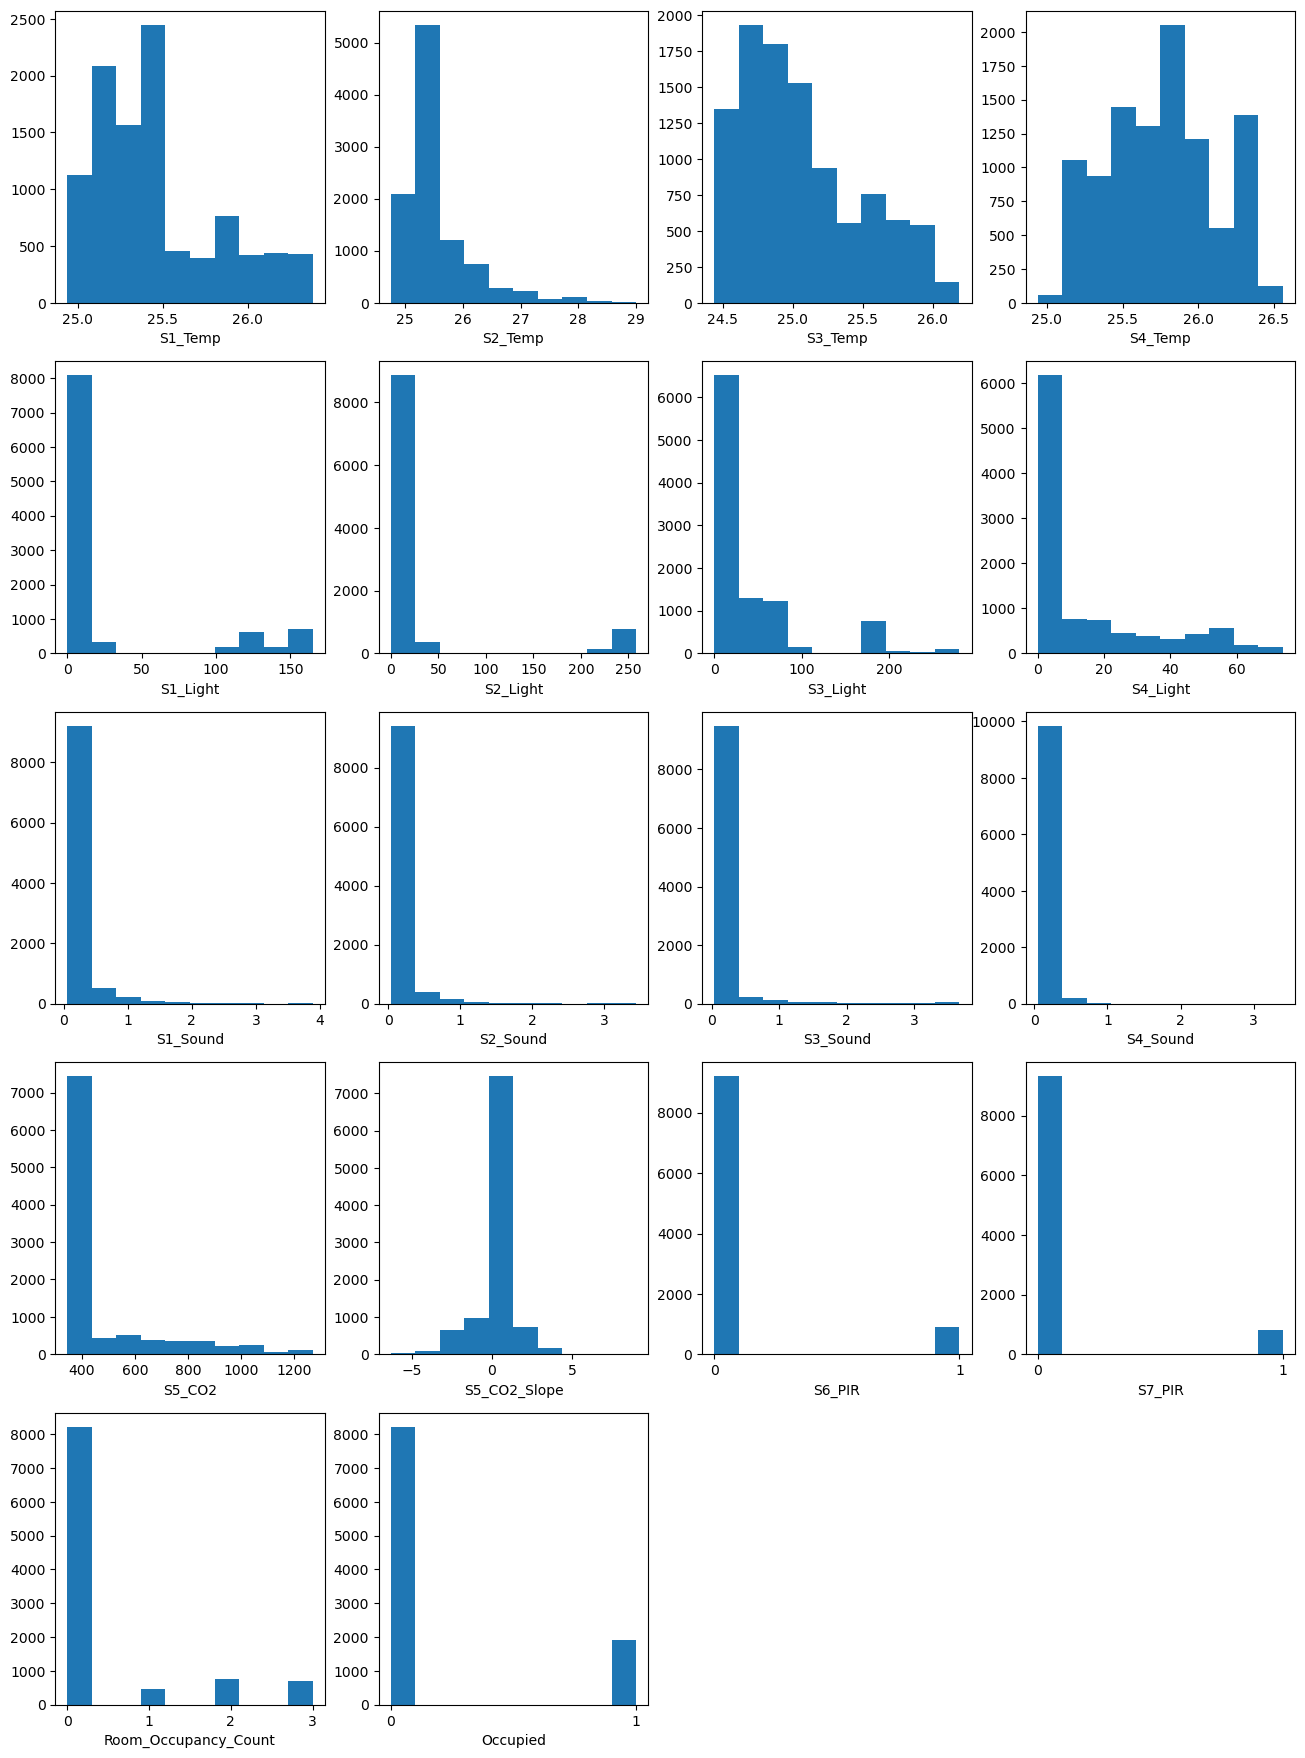

In [8]:
# Create Histograms for features to visualize distributions
columns = df.columns[1:]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,22))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(columns):
        break
    # plot histogram
    ax.hist(df[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
axes[4][2].remove()
axes[4][3].remove()
axes[3][2].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[3][3].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[4][1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

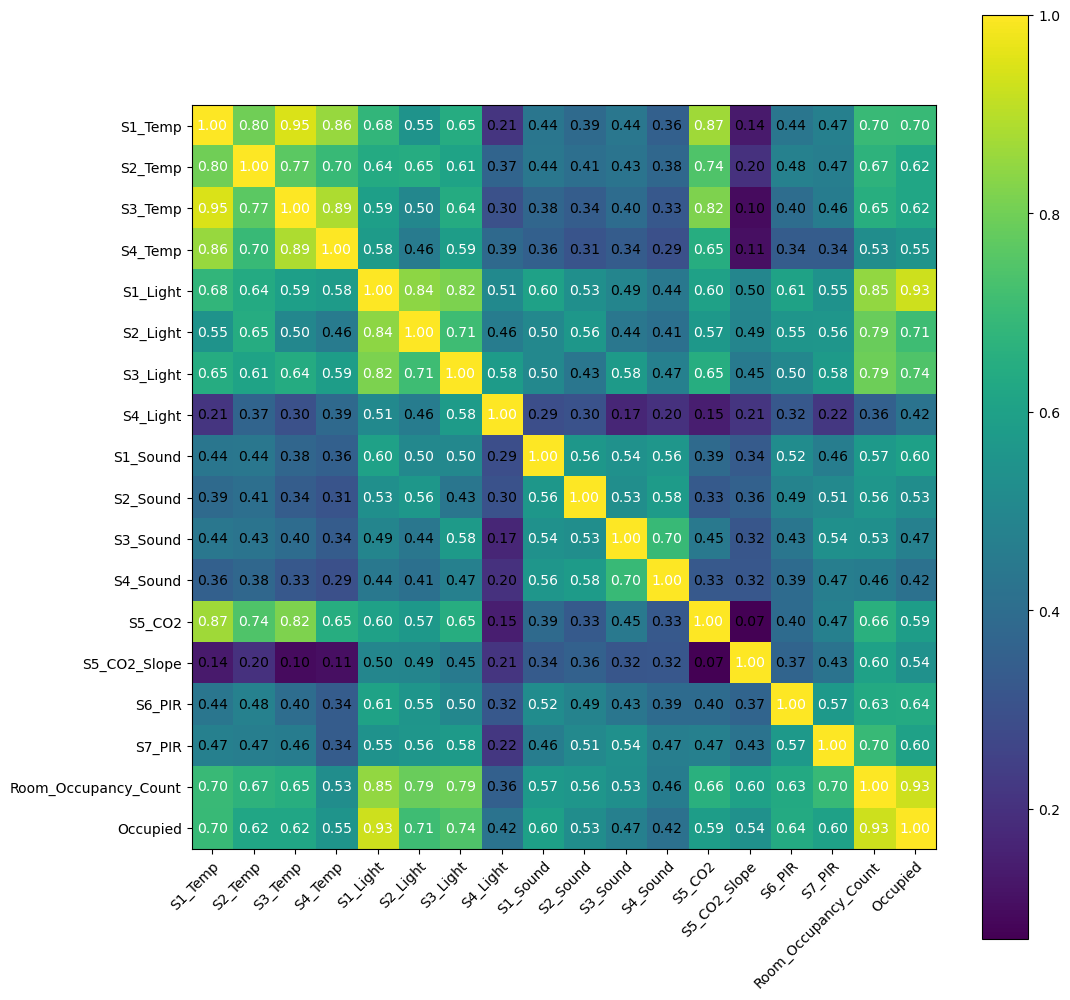

In [9]:
# Create correlation heat map to view correlations between features
columns = df.columns[1:]

cm = df[columns].corr().values 
hm = heatmap(
    cm,
    row_names=columns,
    column_names=columns,
    cmap='viridis',
    figsize=(12,12)
)

Min/Max Occupied Time: 10:49:41/19:51:46
Min/Max Unoccupied Time: 00:00:28/23:59:58
Total count of records after downsampling: 3590
Value counts for each class after downsampling:
0    1689
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64


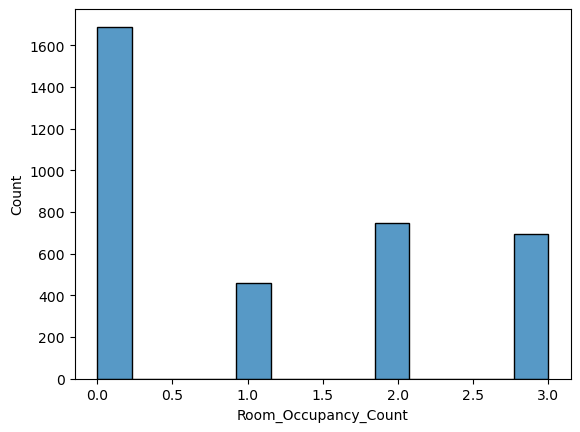

In [10]:
# Attempt to correct for class imbalance of Room_Occupancy_Count
# Downsample the majority class (Room_Occupancy_Count == 0)
# by keeping only records between the min_occupied_time and max_occupied_time 

# Define min and max occupied time
min_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.max()

# Define min and max unoccupied time
min_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.min()
max_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.max()

print(f"Min/Max Occupied Time: {min_occupied_time}/{max_occupied_time}")
print(f"Min/Max Unoccupied Time: {min_unoccupied_time}/{max_unoccupied_time}")

# determine number of records remainging after downsampling the majority class
record_count_after_filter = df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"].count()
print('Total count of records after downsampling:', record_count_after_filter)
room_occupancy_value_count_after_filter = df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"].value_counts()
print('Value counts for each class after downsampling:')
print(room_occupancy_value_count_after_filter)

sns.histplot(df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"])
plt.show()

# Model Pipeline

## Imports, Load Data, Preprocessing and Feature Engineering

### Imports

In [11]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf
import tensorflow_addons as tfa

from mlxtend.plotting import heatmap
import seaborn as sns
import pprint
import graphviz

import os
from IPython.display import display

pp = pprint.PrettyPrinter()

### Define helper functions

In [12]:
# Andre's function to split the dataset into train, validation, and test data
def split_data(X, y, split=(0.6, 0.2, 0.2), seed=888):
  """
  Splits X/y into training, validation, and testing sets based on the
  specified split.

  Parameters
  ----------
  X : np.ndarray
    An array-like collection of sample points
  y : np.ndarray
    The class labels of the data, should match the length of data
  split : tuple
    The percentage allocation of training, validation, and test datasets

  Returns
  -------
  splits : tuple
    The training, validation, and test datasets with their labels
    Defaults to a train/validation/test split of 60%/20%/20%
  """
  # Input checking
  if len(X) != len(y):
    raise ValueError(f"X and y lengths don't match ({len(X)} != {len(y)})")
  if len(split) != 3:
    raise ValueError("Invalid split, expected 3 percentages (training, validation, test)")
  if sum(split) != 1:
    raise ValueError(f"Invalid split {split}, percentages must sum to 1!")
  if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
    raise TypeError("X and y must be numpy arrays")

  # Initial split for testing data
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
      X, y, test_size=split[2], random_state=seed, stratify=y)

  # Further split for validation data
  val_size = split[1] / (1 - split[2])
  X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
      X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
def calculate_f1_scores(true_labels, predicted_labels, labels=[0, 1, 2, 3], print_output=True):
    """
    Calculates the macro average f1-score, micro average f1-score, and weighted
    average f1-score from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]
    print_output : bool
        Whether to print the metrics out or not
        Default : True

    Returns
    -------
    macro_avg_f1 : float
        The macro average f1-score for the model. The function calculates the f1-score
        for each class individually and takes the unweighted mean of all values    
    micro_avg_f1 : float
        The micro average f1-score for the model. The function considers the total
        True Negatives (TN) and total False Positives (FP) amongst all classes and
        calculates the f1-score globally for the model
    weighted_avg_f1: float
        The support weighted average f1-score for the model. The function calculates
        the f1-score for each class individually and takes the weighted mean of all
        values based on the support of each class
    """

    # Calculate metrics
    macro_avg_f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, labels=labels, average="macro")
    micro_avg_f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, labels=labels, average="micro")
    weighted_avg_f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, labels=labels, average="weighted")

    # Print metrics
    if print_output:
        print("F1-Scores")
        print("---------")
        print(f"Macro average: {macro_avg_f1:9.4f}")
        print(f"Micro average: {micro_avg_f1:9.4f}")
        print(f"Weighted average: {weighted_avg_f1:.4f}\n")

    return macro_avg_f1, micro_avg_f1, weighted_avg_f1

In [14]:
# Dakota's function to calculate specificities for each class
def calculate_specificities(true_labels, predicted_labels, labels=[0, 1, 2, 3]):
    """
    Calculates the macro average specificity, micro average specificity and weighted average specificity
    from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]

    Returns
    -------
    macro_avg_specificity : float
        The macro average specificity for the model. The function calculates specificity for each class individually
        and takes the unweighted mean of all values    
    micro_avg_specificity : float
        The micro average specificity for the model. The function considers the total True Negatives (TN) and total False Positives (FP)
        amongst all classes and calculates specificity globally for the model
    weighted_avg_specificity: float
        The support weighted average specificity for the model. The function calculates specificity for each class individually
        and takes the weighted mean of all values based on the support of each class
    
    """

    # Calculate TN / TP / FN / FP
    mcm = sklearn.metrics.multilabel_confusion_matrix(true_labels, predicted_labels, labels=labels)
    TN = mcm[:,0,0]
    TP = mcm[:,1,1]
    FN = mcm[:,1,0]
    FP = mcm[:,0,1]

    # Calculate specificity for each class (TN/(TN+FP))
    specificity = TN / (TN+FP)
    print('\nspecificity for each class [0, 1, 2, 3]:', specificity)

    # calculate macro specificity
    macro_avg_specificity = round((sum(specificity)/len(specificity)),5)

    # calculate micro specificity
    micro_avg_specificity = round((sum(TN)/(sum(TN)+sum(FP))),5)
    
    support = np.unique(true_labels, return_counts=True)[1]
    weights = support/sum(support)
    weighted_avg_specificity = round(sum(specificity*weights),5)

    print('Macro Specificity:', macro_avg_specificity)
    print('Micro Specificity:', micro_avg_specificity)
    print('Weighted Specificity:', weighted_avg_specificity)

    return macro_avg_specificity, micro_avg_specificity, weighted_avg_specificity

In [15]:
# Dakota's function to automate decision tree output 
def get_decision_tree(criterion='gini', max_depth=None):
    max_depth = max_depth
    criterion = criterion
    dt_clf = DecisionTreeClassifier(criterion=criterion, random_state=888, max_depth=max_depth)
    # Instatiate tree classifier
    dt_clf = dt_clf.fit(X_train, y_train)

    # Predict the validation data and the probabilities
    y_val_pred = dt_clf.predict(X_val)
    y_val_pred_prob = dt_clf.predict_proba(X_val)

    macro_f1_tree, micro_f1_tree, weighted_f1_tree = calculate_f1_scores(y_val, y_val_pred)

    sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # pp.pprint(('Features:', features))
    # pp.pprint(('Feature importances:', dt_clf.feature_importances_))
    # Plot decision tree with graphviz
    dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                    feature_names=features,
                                    class_names=['0','1','2','3'],
                                    filled=True, rounded=True,
                                    special_characters=True,
                                    # leaves_parallel=True,
                                    )
    graph = graphviz.Source(dot_data, format='svg')
    display(graph)

    return macro_f1_tree, micro_f1_tree, weighted_f1_tree


In [16]:
# Dakota's function to automate decision tree output 
def get_gboost_decision_tree(learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0):
    learning_rate = learning_rate
    n_estimators = n_estimators
    max_depth = max_depth
    subsample = subsample
    gboost_dt_clf = GradientBoostingClassifier(learning_rate = learning_rate,
                                               n_estimators = n_estimators,
                                               max_depth = max_depth,
                                               subsample = subsample,
                                               random_state=888)
    # Fit classifier to X_train and y_train
    gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

    # Predict the validation data and the probabilities
    y_val_pred = gboost_dt_clf.predict(X_val)
    y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

    macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

    sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot final tree
    # gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]
    # dot_data = tree.export_graphviz(gboost_dt_clf, out_file=None,
    #                                 feature_names=features,
    #                                 class_names=['0','1','2','3'],
    #                                 filled=True, rounded=True,
    #                                 special_characters=True,
    #                                 # leaves_parallel=True,
    #                                 )
    # graph = graphviz.Source(dot_data, format='svg')
    # display(graph)

    return macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree

### Load Data and Prepare Data

In [17]:
# Get current working directory for repo
working_dir = os.getcwd()

# read the original / raw Occupancy_Estimation.csv data source
df = pd.read_csv(working_dir + '/data/raw/Occupancy_Estimation.csv')

# Combine date and time into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)
df.drop(columns=["Date", "Time"], inplace=True)

# Create labels and features variables for later use
# labels = df.columns[-1]

features = df.columns[:-1]
labels = df.columns[-1]

# Generate numpy arrays of data
X = df[features].values # Exclude Room_Occupancy_Count
y = df[labels].values

# Split data into train/validation/test sets with default 60/20/20 split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

## Correct class imbalance of Room_Occupancy_Count in training data
# Find min/max occupied times
min_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.max()

# Downsample majority class in training data
mask_func = np.vectorize(lambda x: (x.time() > min_occupied_time) & (x.time() < max_occupied_time))
mask = mask_func(X_train[:, 0])

X_train = X_train[mask]
y_train = y_train[mask]

# Get rid of timestamp columns
X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
X_test = X_test[:, 1:]

# Redefine features without Timestampe for later use
features = df.columns[1:17]

# Standardize data
std_scaler = sklearn.preprocessing.StandardScaler()

X_train_std = std_scaler.fit(X_train).transform(X_train)
X_val_std = std_scaler.fit(X_train).transform(X_val)
X_test_std = std_scaler.fit(X_train).transform(X_test)

## Baseline Model (always predict unoccupied / Room_Occupancy_Count == 0)

F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8124
Weighted average: 0.7284



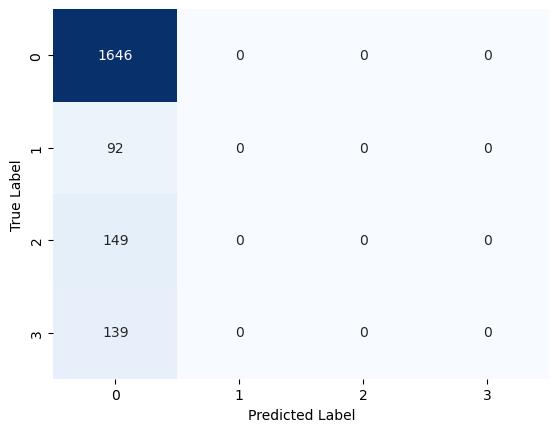

In [18]:
### Create baseline model
# Baseline model always predicts Room_Occupancy_Count == 0
baseline_pred = np.zeros(y_test.shape)

### Evaluate specificity of baseline model
# Evaluate model by calculating Macro, Micro, and Weighted Specificities
macro_f1_baseline, micro_f1_baseline, weighted_f1_baseline = calculate_f1_scores(y_test, baseline_pred)

# Create confusion matrix for actual and baseline predictions of y_test
conf_mat_baseline = sklearn.metrics.confusion_matrix(y_test, baseline_pred)
conf_mat_baseline = sns.heatmap(conf_mat_baseline, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Decision Trees

### Decision Tree (determine importance of all features with default values)

F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



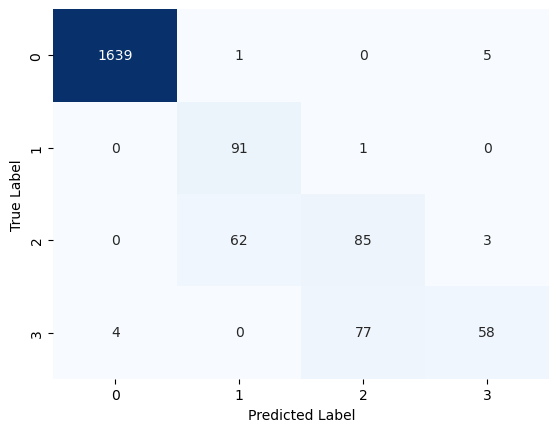

,Feature,Feature Importance
4,S1_Light,0.469596
5,S2_Light,0.243592
6,S3_Light,0.114900
13,S5_CO2_Slope,0.114366
11,S4_Sound,0.021496
9,S2_Sound,0.019850
3,S4_Temp,0.009185
10,S3_Sound,0.003686
7,S4_Light,0.002346
8,S1_Sound,0.000984


In [19]:
### Create dataframe to store evaluation metrics of each tree
df_tree_f1s = pd.DataFrame(columns=['Criterion','Tree Depth', 'Macro F1', 'Micro F1', 'Weighted F1'])
### Create decision tree with no max_depth limit to determine feature importance
## Create decision tree classifier
# Use gini impurity as an intermediate measure between entropy and classification error and minimize probability of misclassification
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888)
# Fit classifier to X_train and y_train
dt_clf = dt_clf.fit(X_train, y_train)
# Predict the validation data and the probabilities
y_val_pred = dt_clf.predict(X_val)
y_val_pred_prob = dt_clf.predict_proba(X_val)

macro_f1_tree, micro_f1_tree, weighted_f1_tree = calculate_f1_scores(y_val, y_val_pred)

sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
# Display feature importance sorted by importance descending
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
display(df_dt_feature_importance)

# plt.bar(range(0, len(df_dt_feature_importance)), df_dt_feature_importance['Feature Importance'])
# plt.xticks(range(0, len(df_dt_feature_importance)), list(df_dt_feature_importance['Feature']), rotation=90)
# plt.show()

Begin tuning the hyperparameters of the decision tree first by adjusting max_depth, then trying criterion='entropy'.

### Decision Tree (criterion='gini', max_depth=1)

F1-Scores
---------
Macro average:    0.3543
Micro average:    0.8569
Weighted average: 0.8196



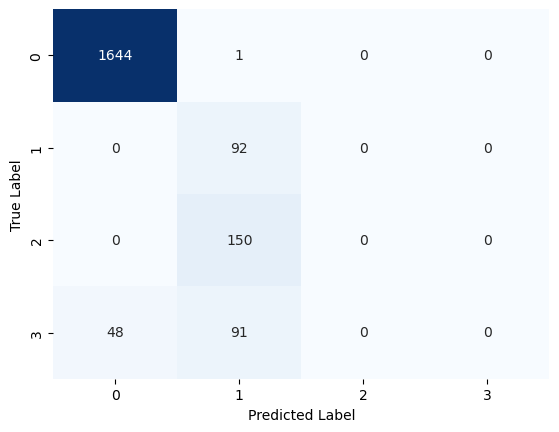

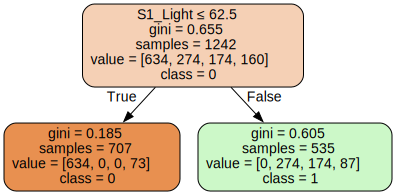

In [20]:
### Create decision tree stump to validate most importance feature (S1_Light)
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=1)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 1, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)


### Decision Tree (criterion='gini', max_depth=2)

F1-Scores
---------
Macro average:    0.6580
Micro average:    0.9107
Weighted average: 0.9060



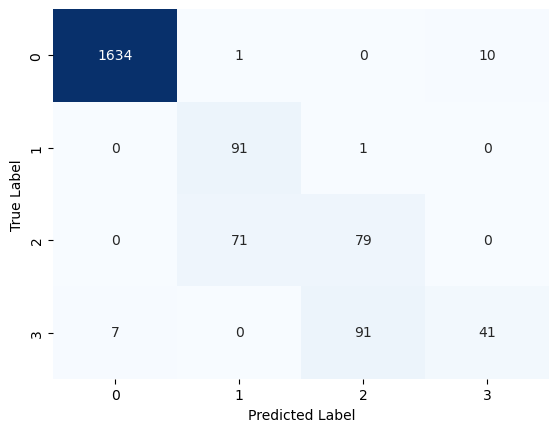

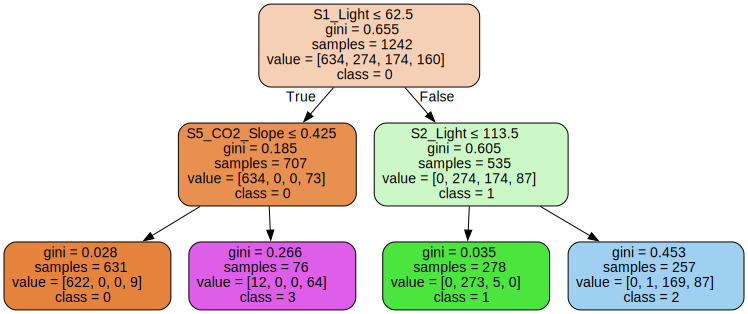

In [21]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=2)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 2, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: 
# model split on S5_CO2_Slope instead of S3_Light which was ID'd as the 3rd most important feature in unlimited depth model

### Decision Tree (criterion='gini', max_depth=3)

F1-Scores
---------
Macro average:    0.8259
Micro average:    0.9561
Weighted average: 0.9538



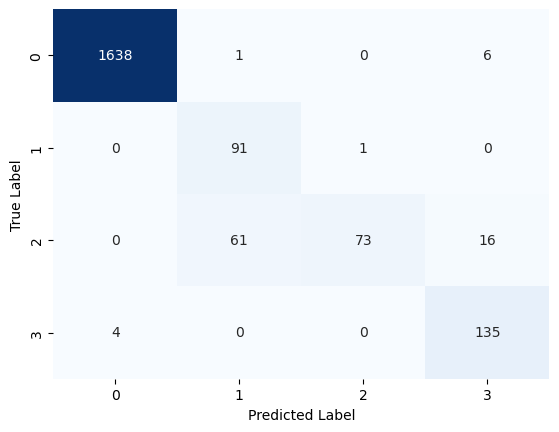

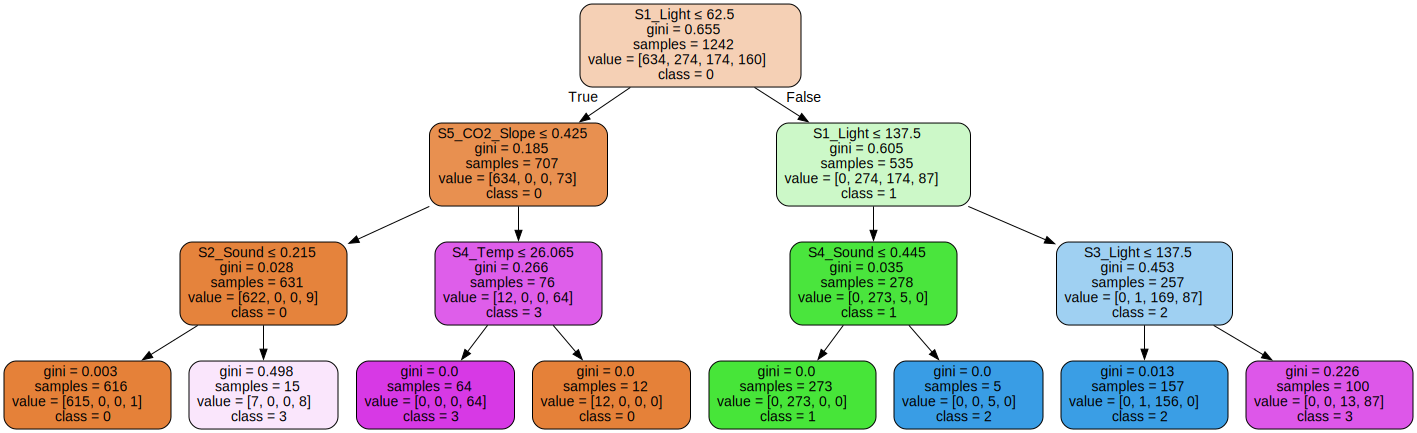

In [22]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=3)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 3, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: 

### Decision Tree (criterion='gini', max_depth=4)

F1-Scores
---------
Macro average:    0.8267
Micro average:    0.9566
Weighted average: 0.9543



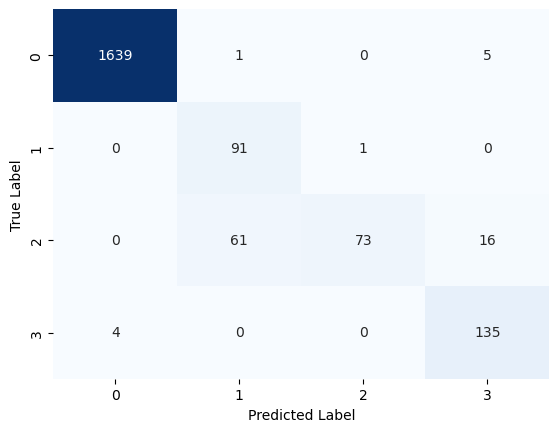

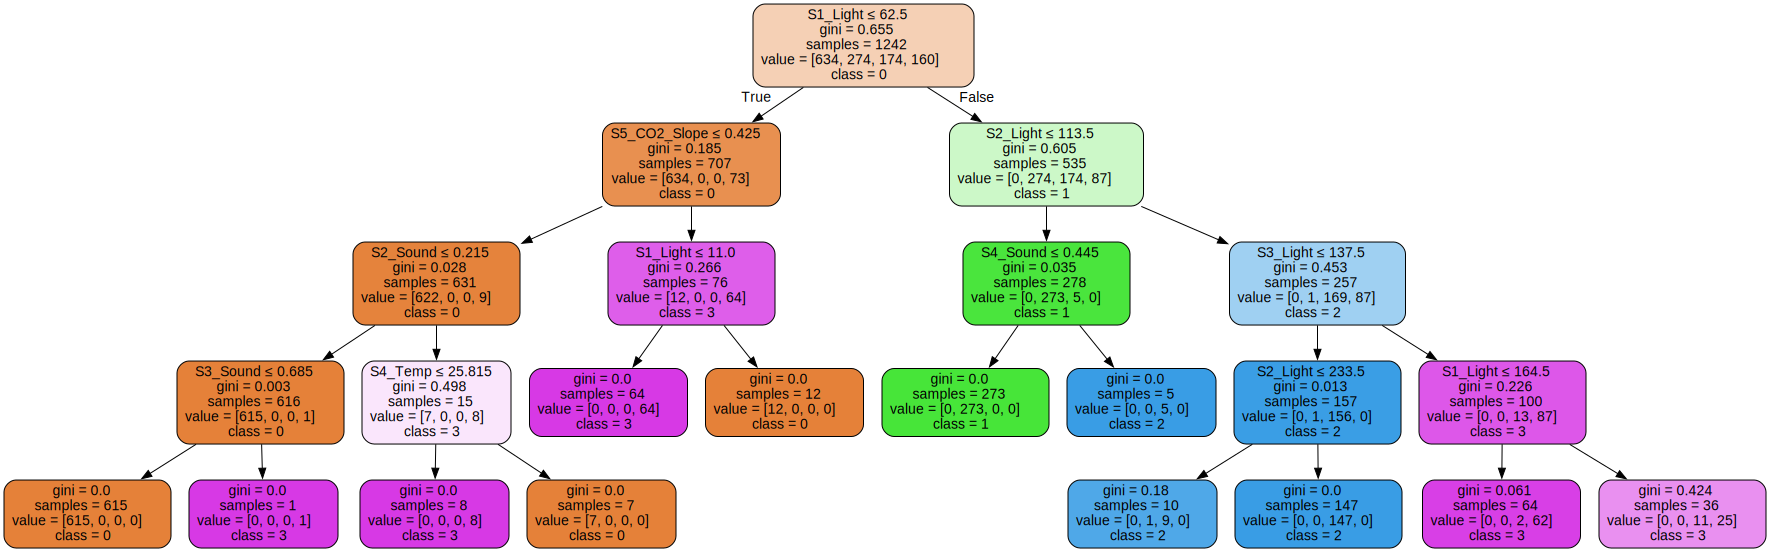

In [23]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=4)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 4, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: Improved performance over max_depth=3 

### Decision Tree (criterion='gini', max_depth=5)

F1-Scores
---------
Macro average:    0.7093
Micro average:    0.9240
Weighted average: 0.9215



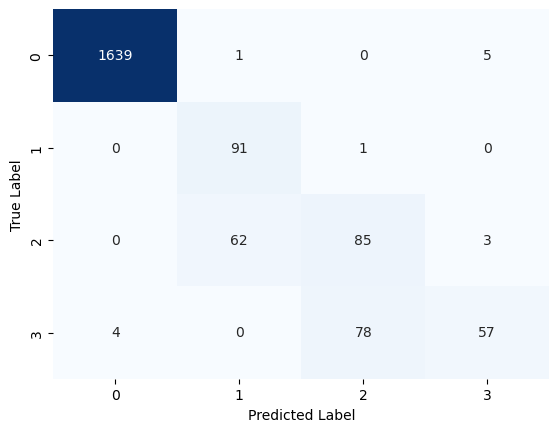

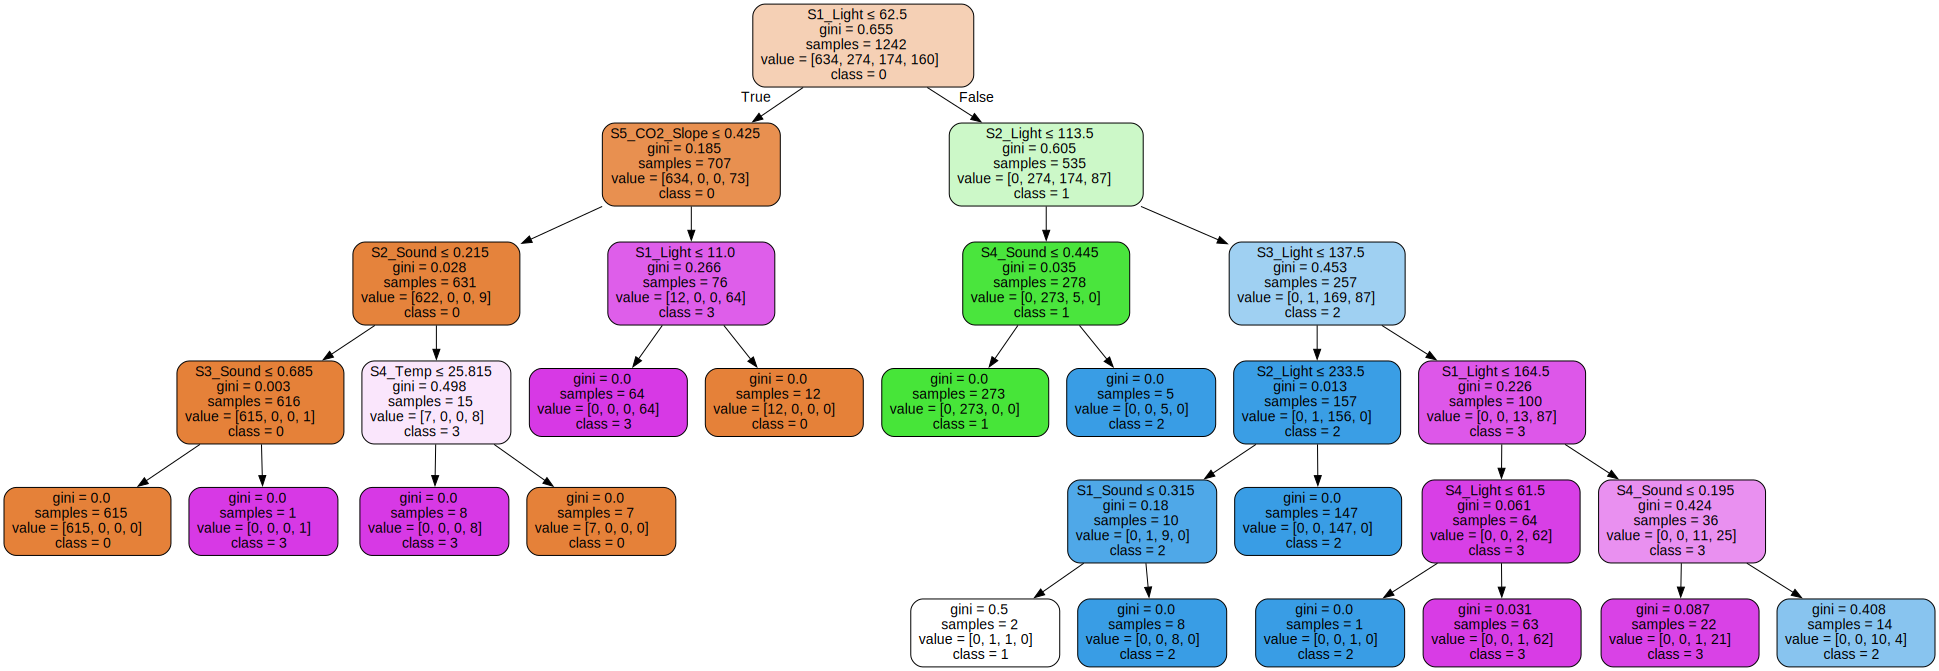

In [24]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=5)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 5, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: 
# Diminished f1-scores for all variations of the metric, possible place to prune (max_depth=4)

### Decision Tree (criterion='gini', max_depth=6)

F1-Scores
---------
Macro average:    0.7093
Micro average:    0.9240
Weighted average: 0.9215



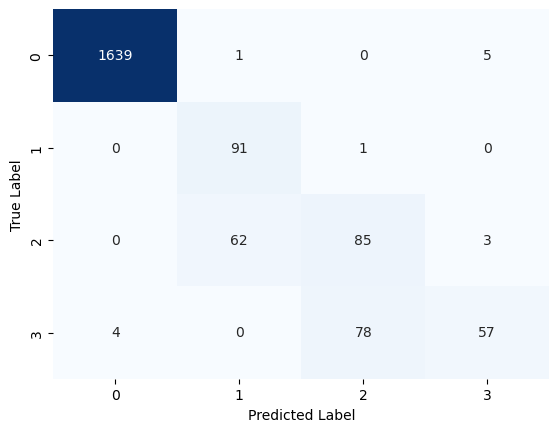

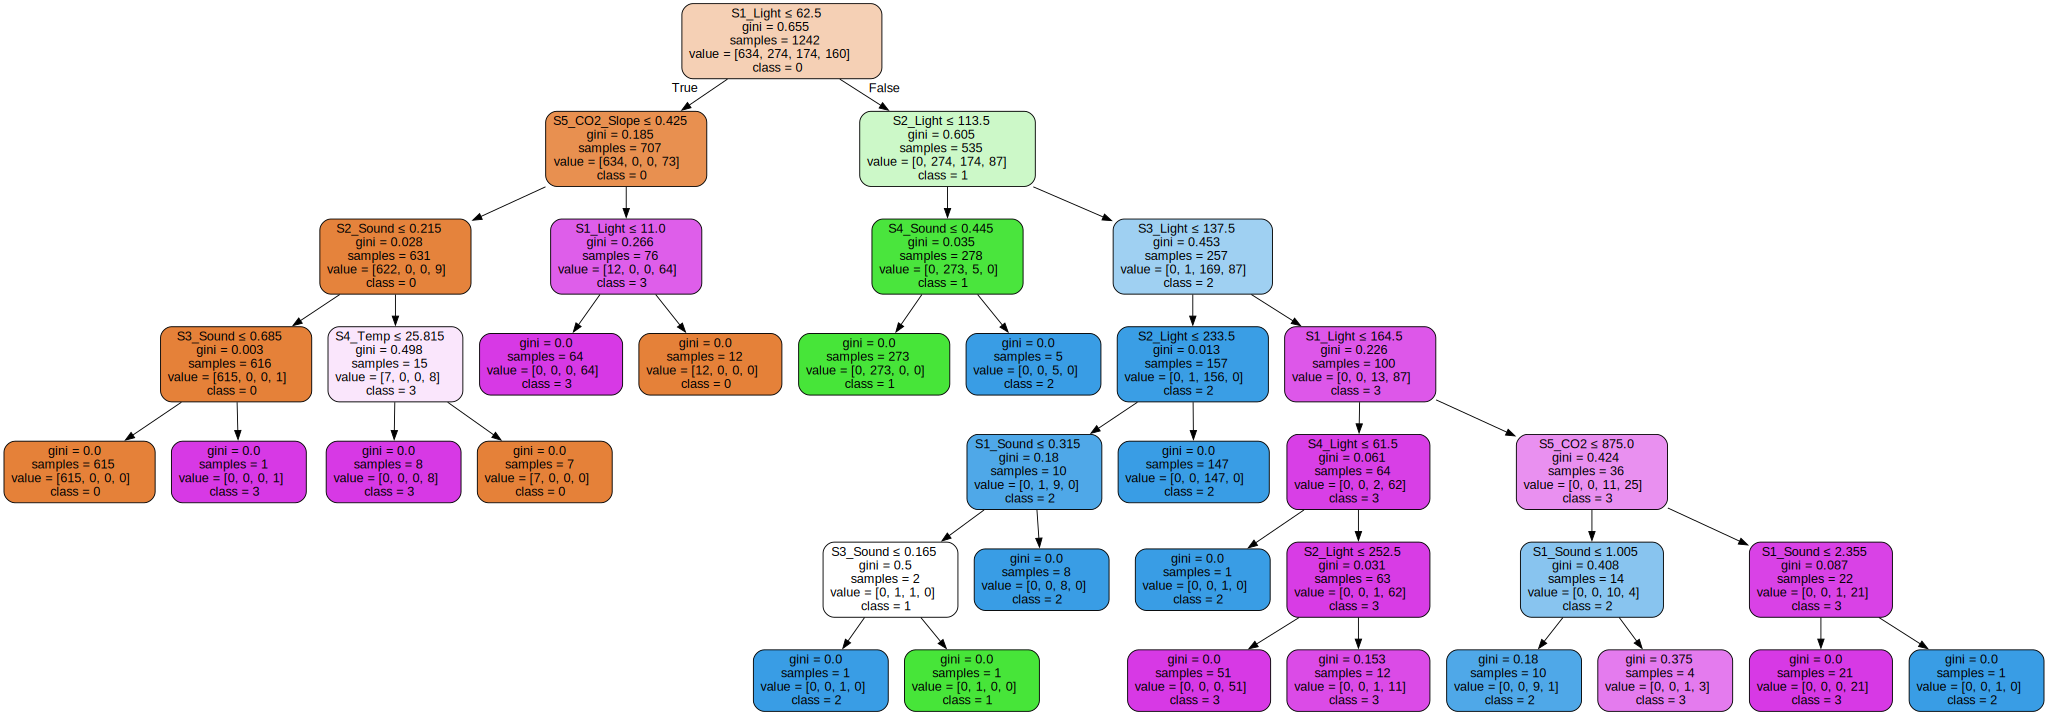

In [25]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=6)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 6, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: 
# Same results with max_depth=5 but deeper tree, no improvement with more complexity

### Decision Tree (criterion='gini', max_depth=7)

F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



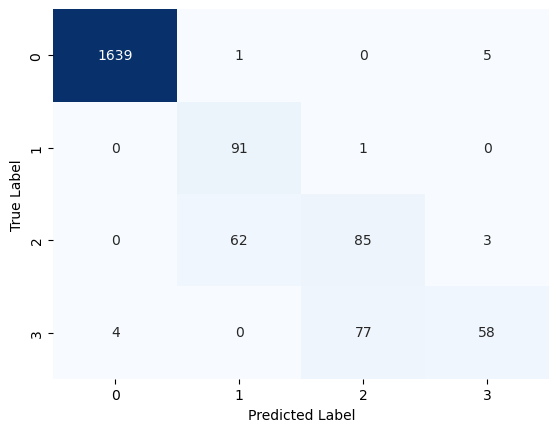

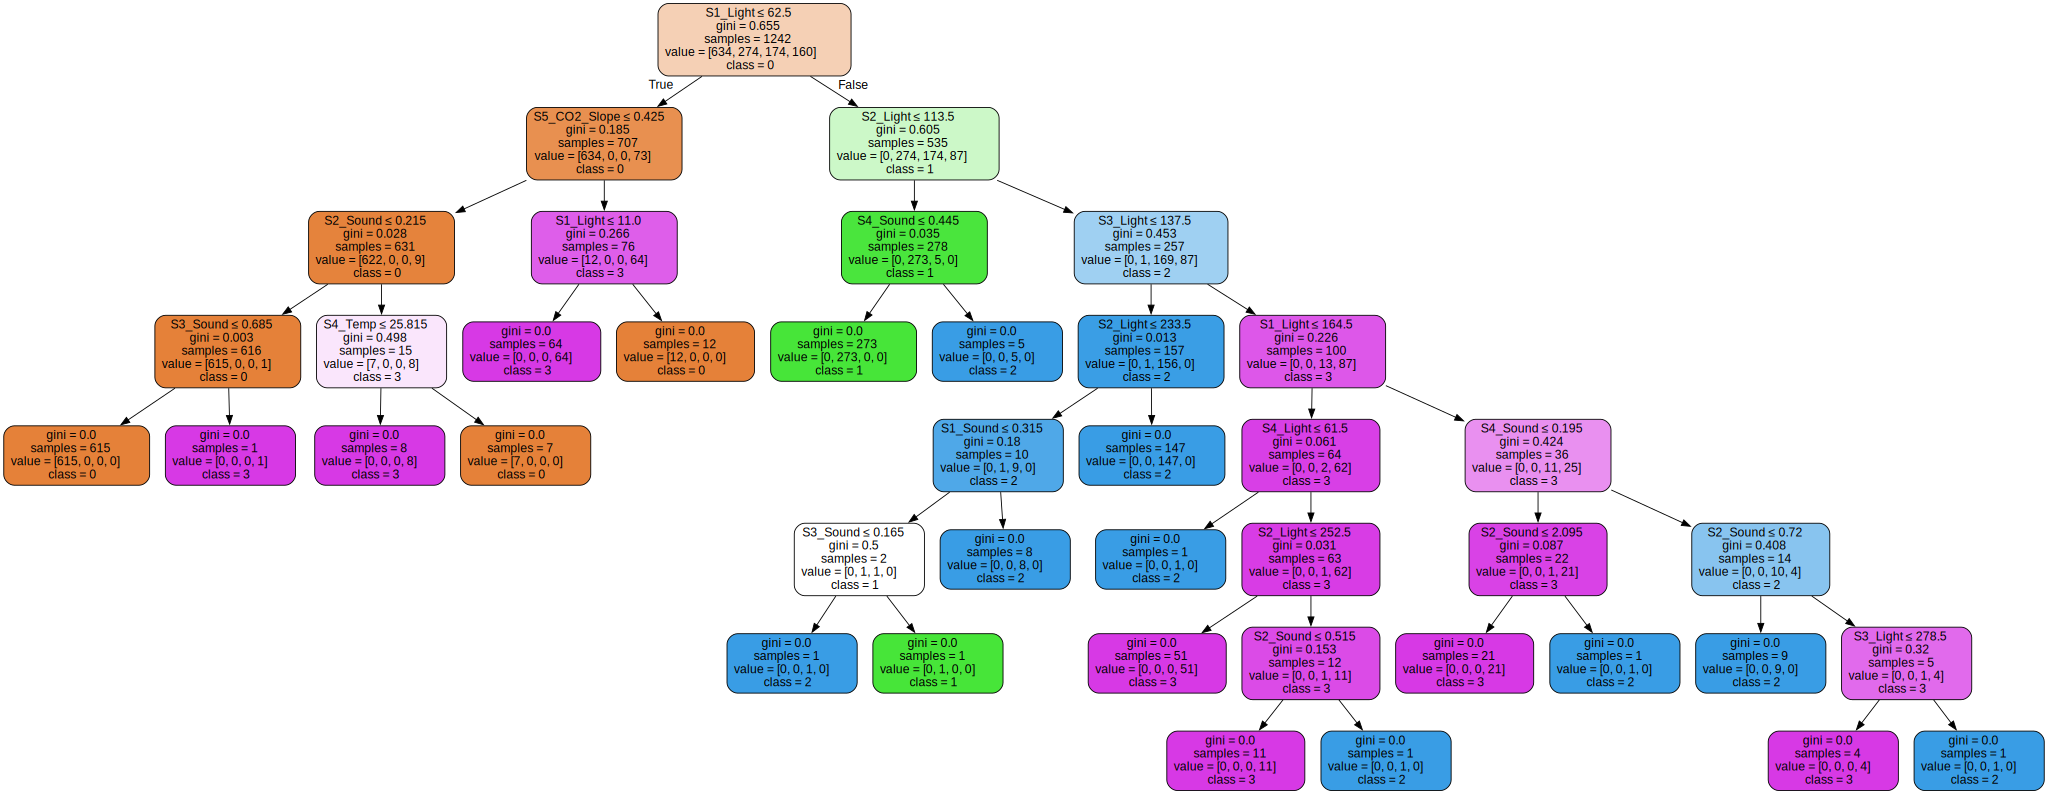

In [26]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=7)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 7, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: 
# Slight improvement over max_depth=6 but still worse than max_depth=4

### Decision Tree (criterion='gini', max_depth=8)

F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



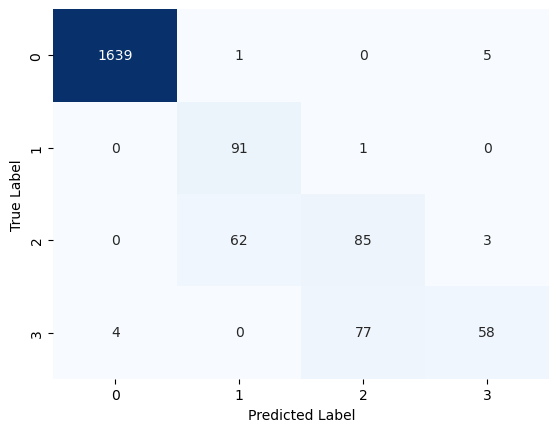

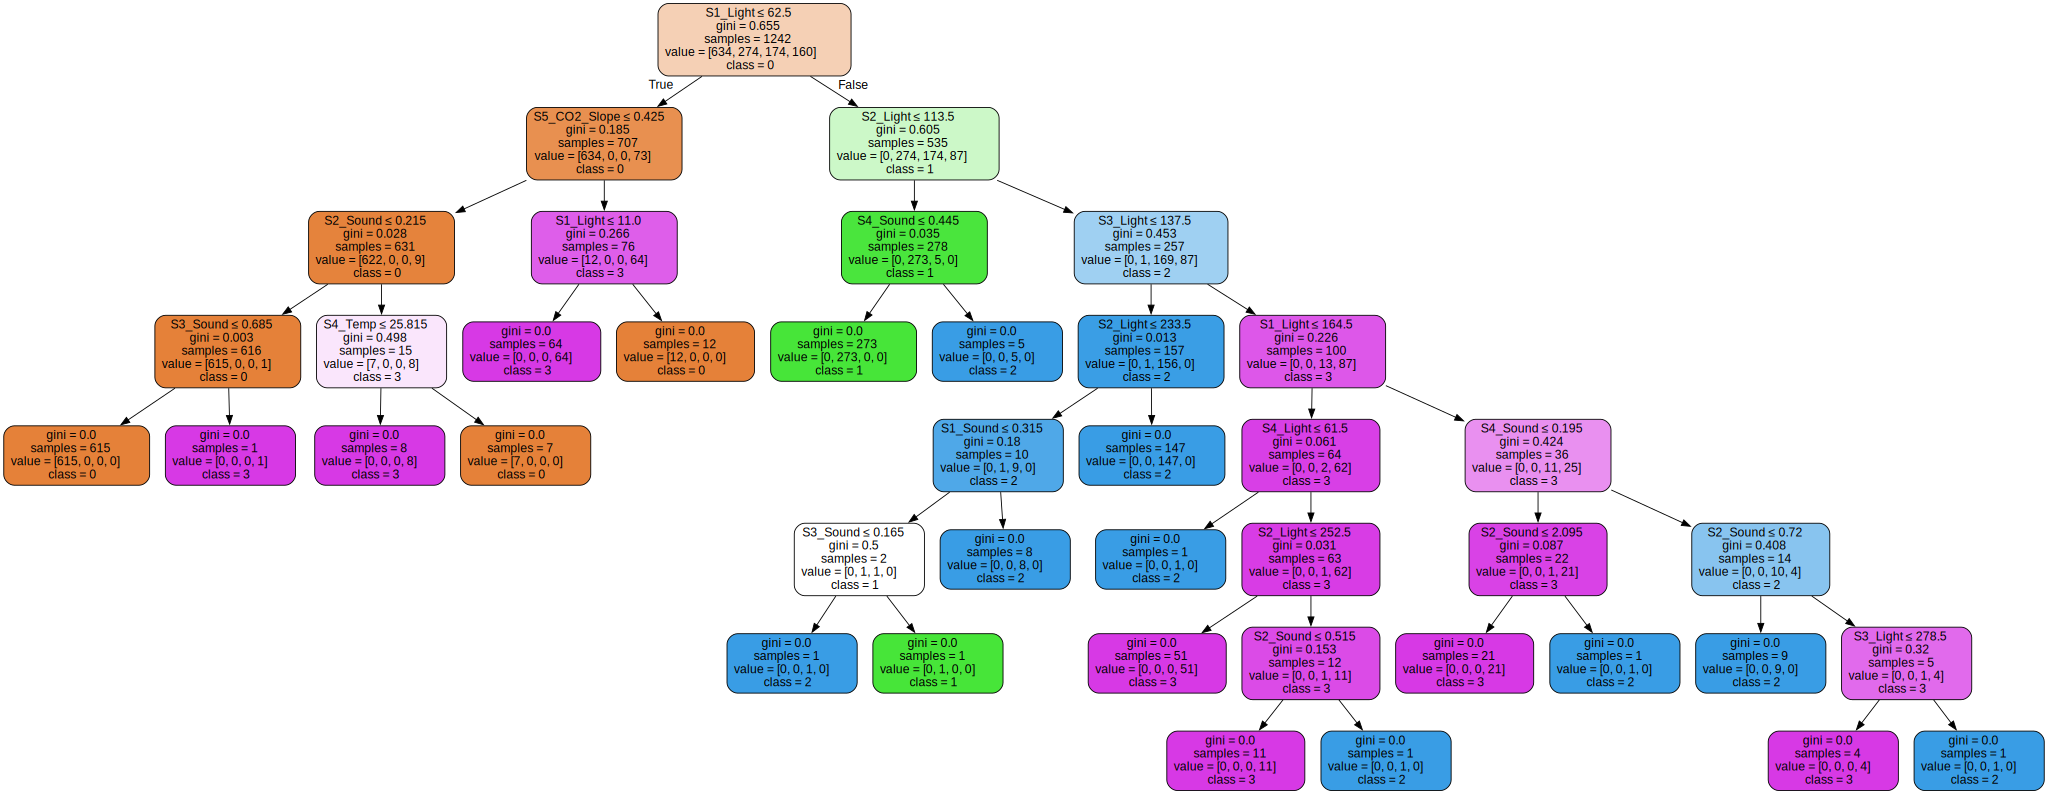

In [27]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(max_depth=8)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Gini', 8, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

## Notes: 
# Same results as max_depth=7 no increase in depth. Stopping point.

### Decision Tree (criterion='entropy', max_depth=1)

F1-Scores
---------
Macro average:    0.3543
Micro average:    0.8569
Weighted average: 0.8196



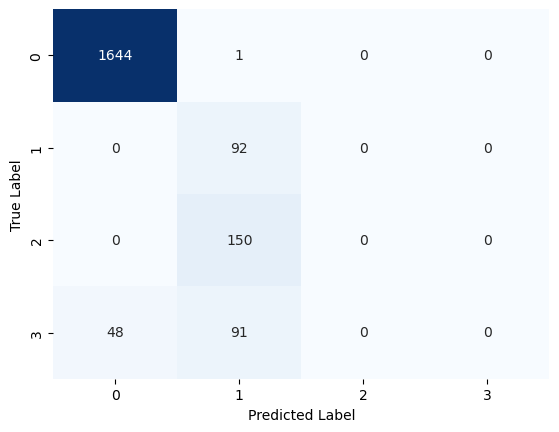

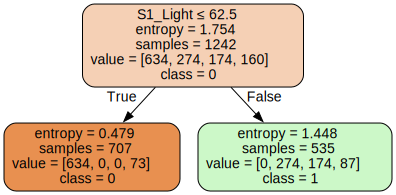

In [28]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=1)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 1, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=2)

F1-Scores
---------
Macro average:    0.6589
Micro average:    0.9057
Weighted average: 0.9039



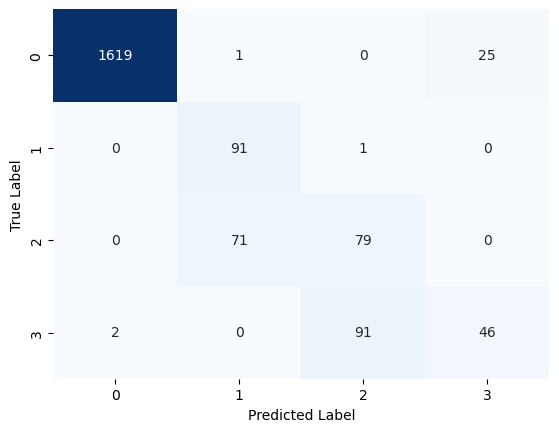

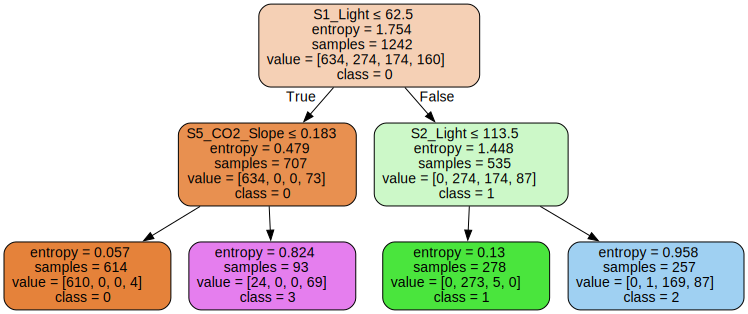

In [29]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=2)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 2, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=3)

F1-Scores
---------
Macro average:    0.8237
Micro average:    0.9546
Weighted average: 0.9525



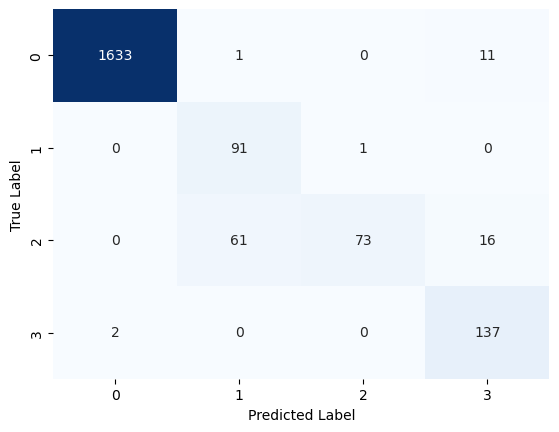

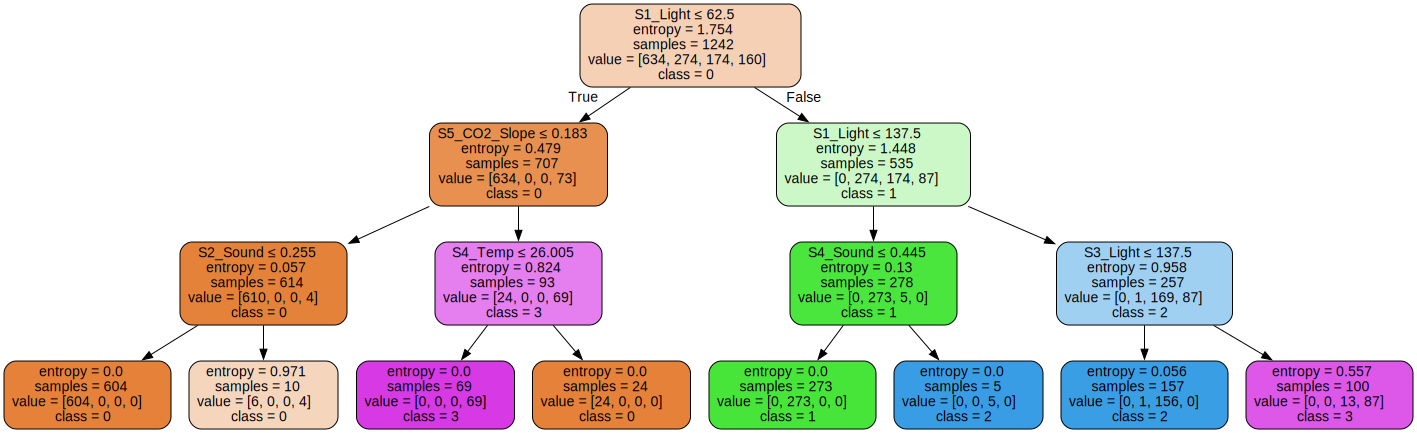

In [30]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=3)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 3, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=4)

F1-Scores
---------
Macro average:    0.8237
Micro average:    0.9546
Weighted average: 0.9525



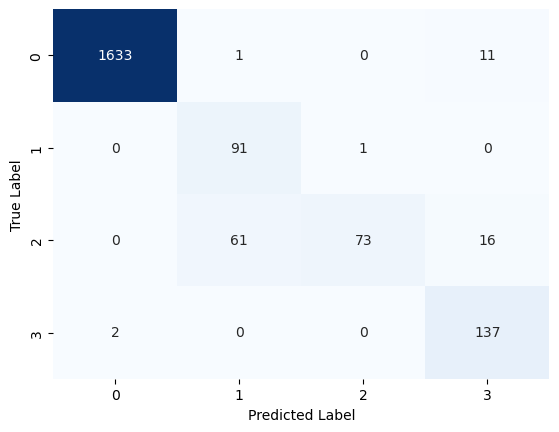

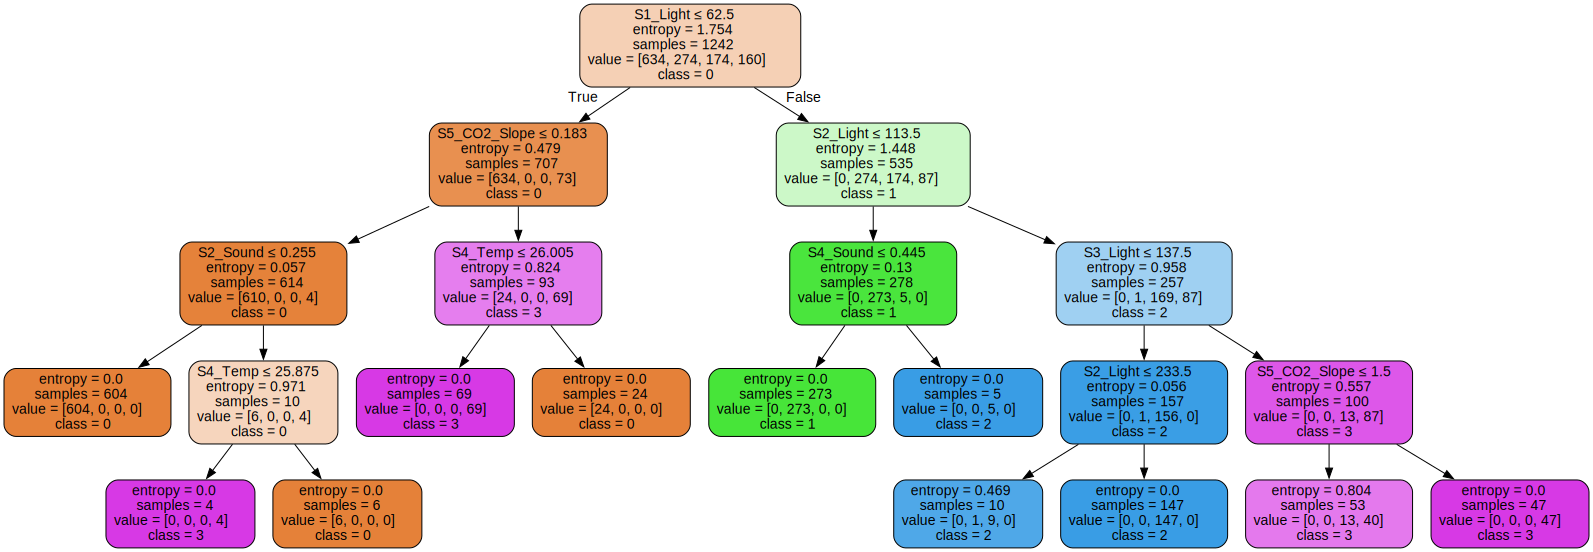

In [31]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=4)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 4, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=5)

F1-Scores
---------
Macro average:    0.8237
Micro average:    0.9546
Weighted average: 0.9525



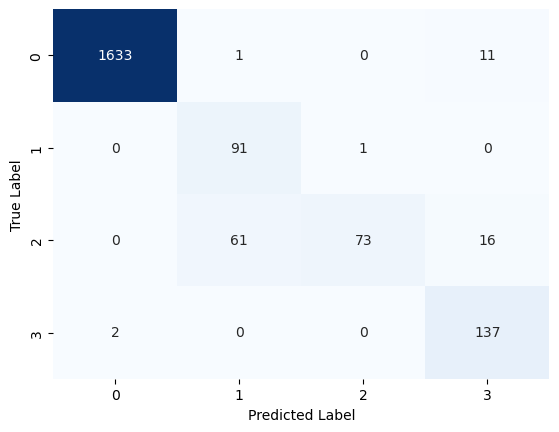

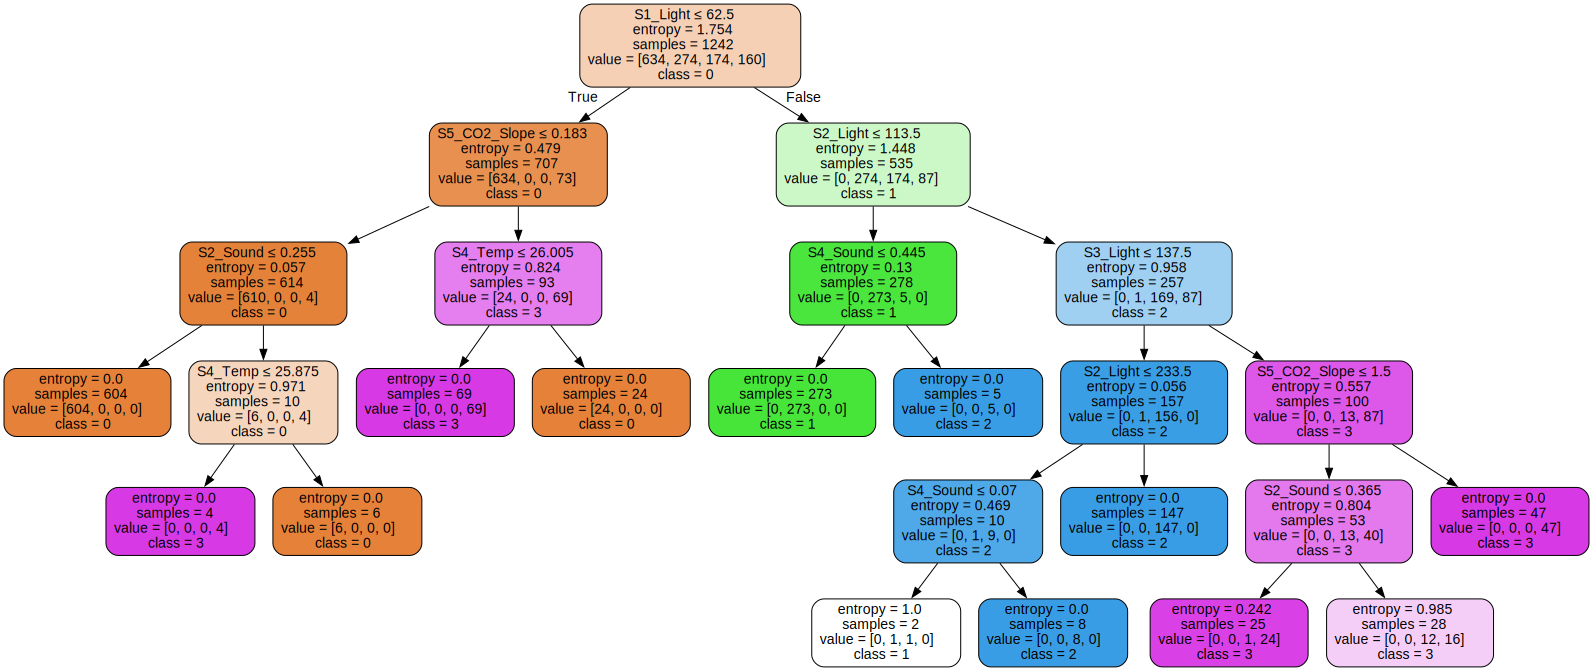

In [32]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=5)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 5, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=6)

F1-Scores
---------
Macro average:    0.8221
Micro average:    0.9531
Weighted average: 0.9521



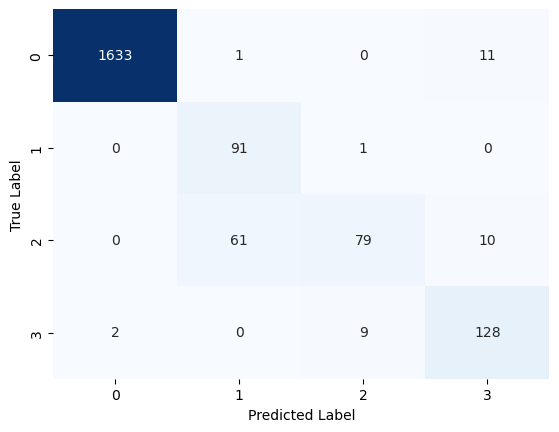

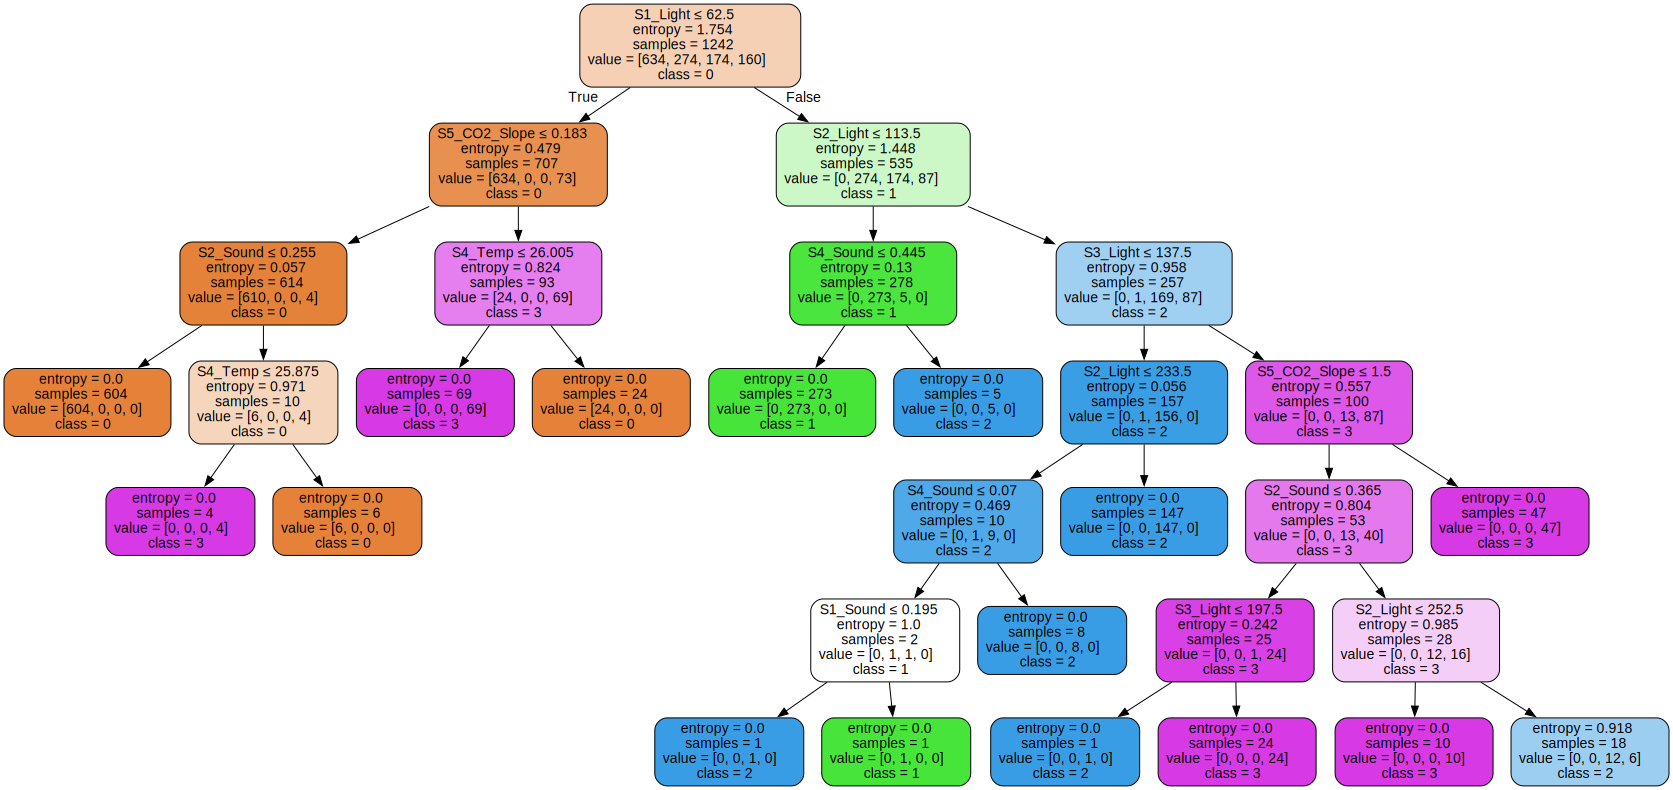

In [33]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=6)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 6, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=7)

F1-Scores
---------
Macro average:    0.8221
Micro average:    0.9531
Weighted average: 0.9521



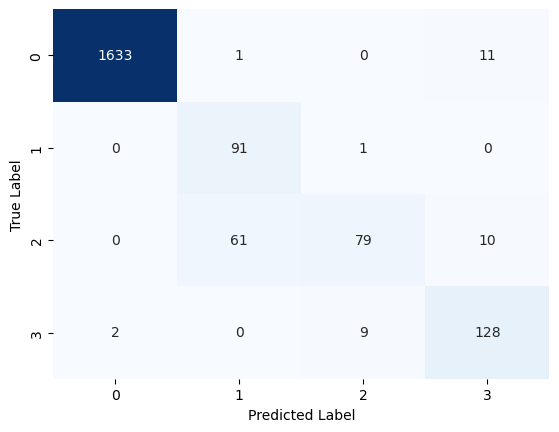

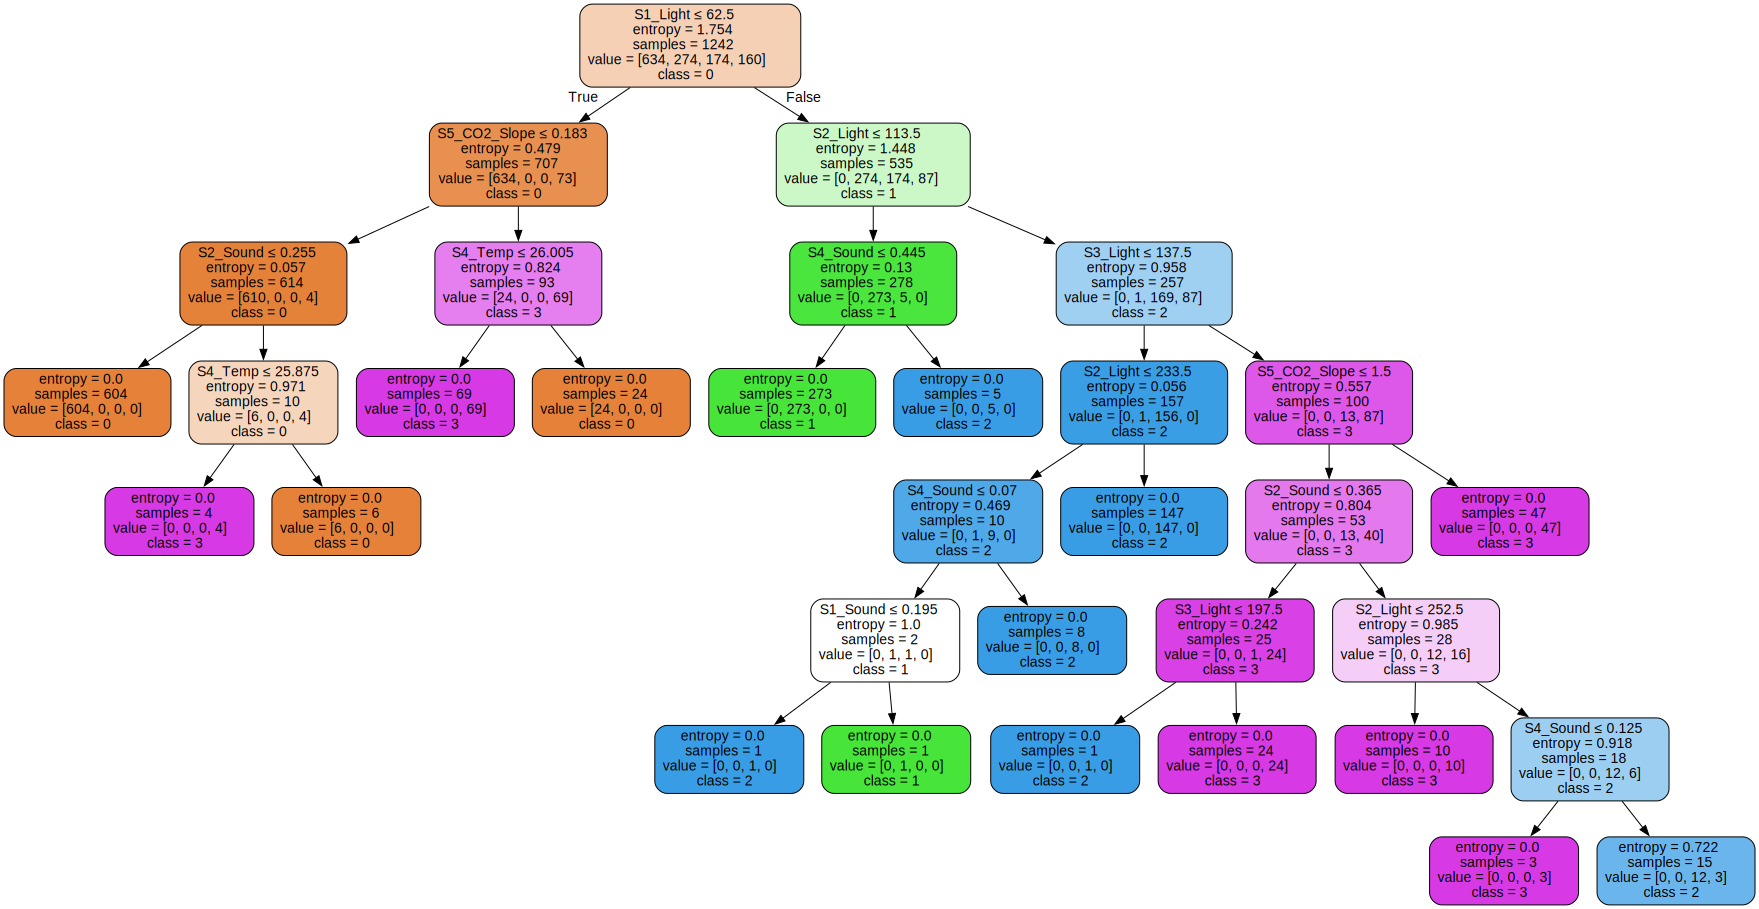

In [34]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=7)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 7, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

### Decision Tree (criterion='entropy', max_depth=8)

F1-Scores
---------
Macro average:    0.8238
Micro average:    0.9536
Weighted average: 0.9526



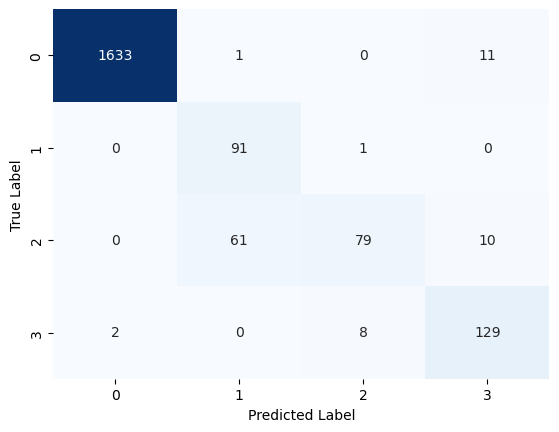

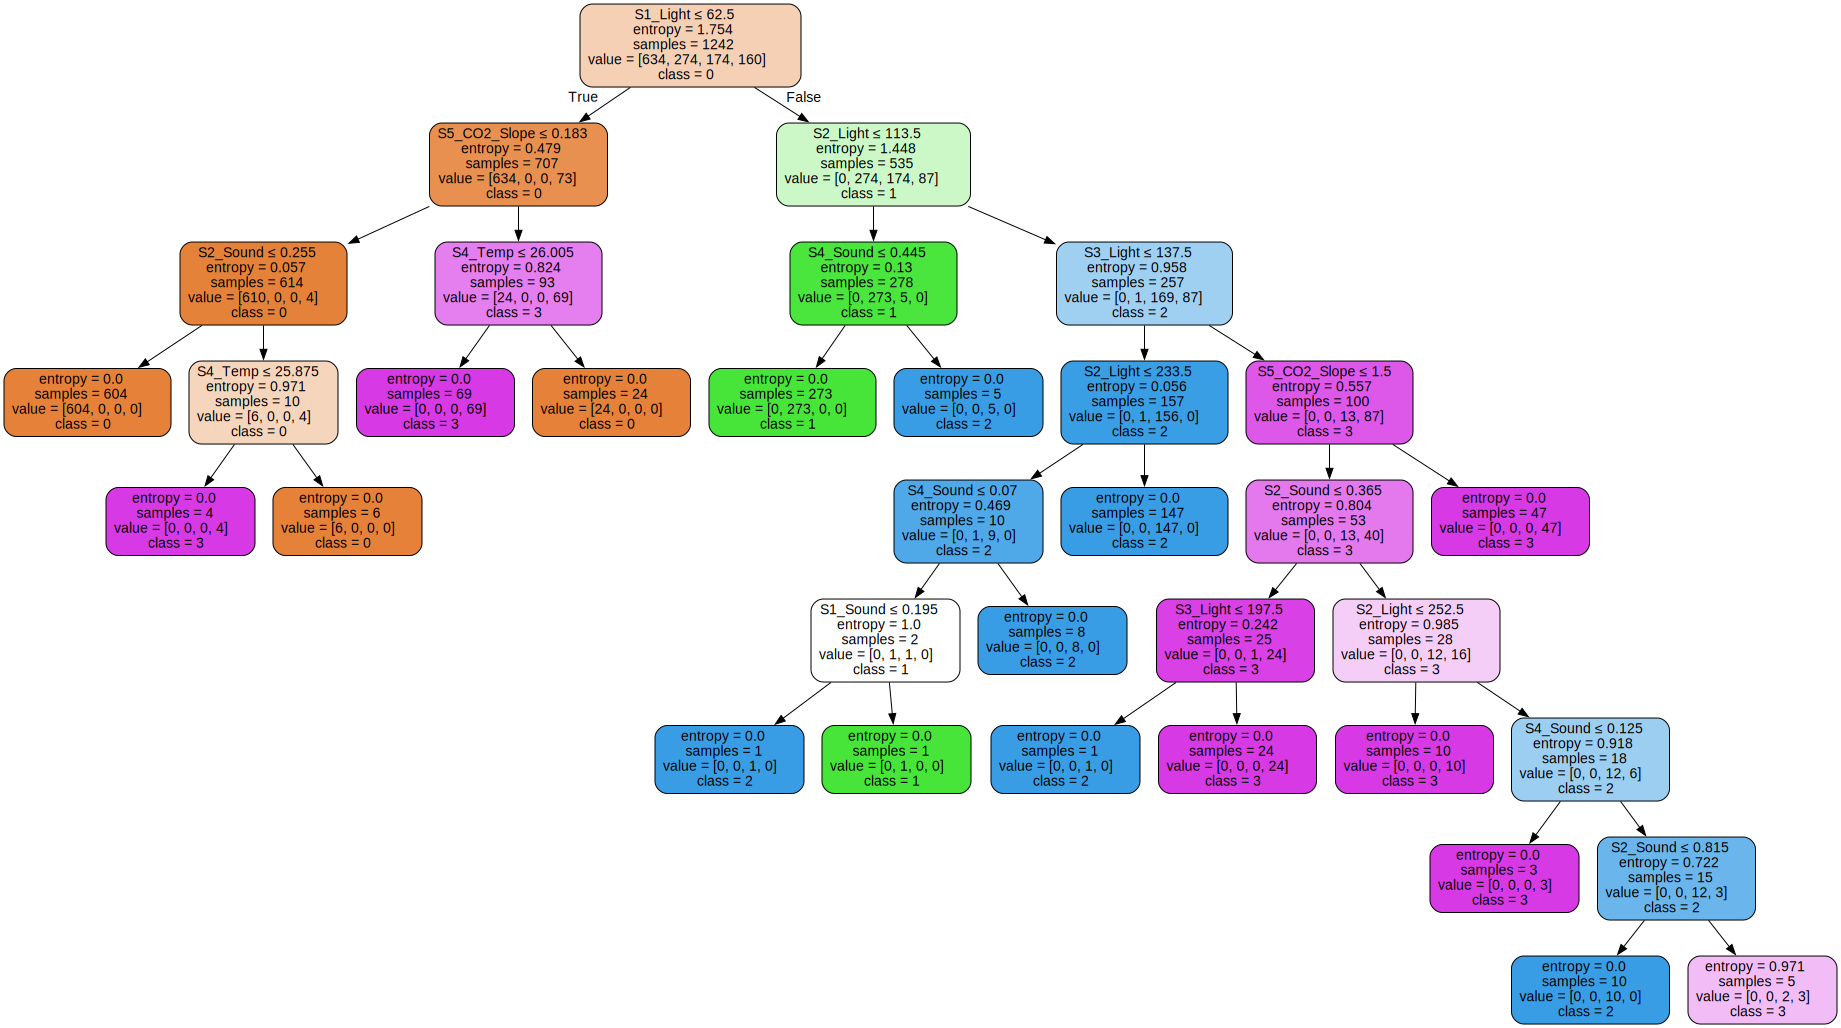

In [35]:
### Create decision tree 
macro_f1_tree, micro_f1_tree, weighted_f1_tree = get_decision_tree(criterion='entropy', max_depth=8)
df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([['Entropy', 8, macro_f1_tree, micro_f1_tree, weighted_f1_tree]], columns=df_tree_f1s.columns)], ignore_index=True)

In [36]:
df_tree_f1s
display(df_tree_f1s)
print('Best max_depth to prune decision tree:')
print(df_tree_f1s[df_tree_f1s['Macro F1']== df_tree_f1s['Macro F1'].max()].to_string(index=False))

# Output indicates max_depth=4 has the optimal F1-scores across the board. Best place to prune.

,Criterion,Tree Depth,Macro F1,Micro F1,Weighted F1
0,Gini,1,0.354310,0.856861,0.819636
1,Gini,2,0.658010,0.910661,0.905959
2,Gini,3,0.825865,0.956071,0.953799
3,Gini,4,0.826714,0.956565,0.954259
4,Gini,5,0.709255,0.923988,0.921495
5,Gini,6,0.709255,0.923988,0.921495
6,Gini,7,0.711445,0.924482,0.922105
7,Gini,8,0.711445,0.924482,0.922105
8,Entropy,1,0.354310,0.856861,0.819636
9,Entropy,2,0.658865,0.905726,0.903893


Best max_depth to prune decision tree:
Criterion Tree Depth  Macro F1  Micro F1  Weighted F1
     Gini          4  0.826714  0.956565     0.954259


Thoughts to further tune the model above: https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- Combine train and validation data, retrain / run decision tree, reprune / analyze max depth
- setting minimum number of samples required at a leaf node
    - min_sample_leaf (try 5 as an intial value, for classification with few classes min_sample_leaf=1 is often the best choice)
- Balance dataset (normalizing sum of the sample_weights for each class to the same value)
    - if samples are weighted, use weight-based pre-pruning criterion (min_weight_fraction_leaf), to ensure the leaf nodes contain at least a fraction of the overall sum of the sample weights
- Minimal cost-complexity Pruning: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
- Use PCA or feature selection beforehand to give tree better chance at finding discriminative features?

### Evaluate Decision Tree on test data (train data only)

F1-Scores
---------
Macro average:    0.8727
Micro average:    0.9684
Weighted average: 0.9673



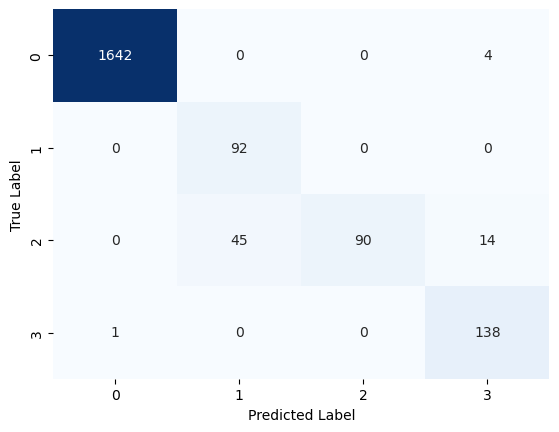

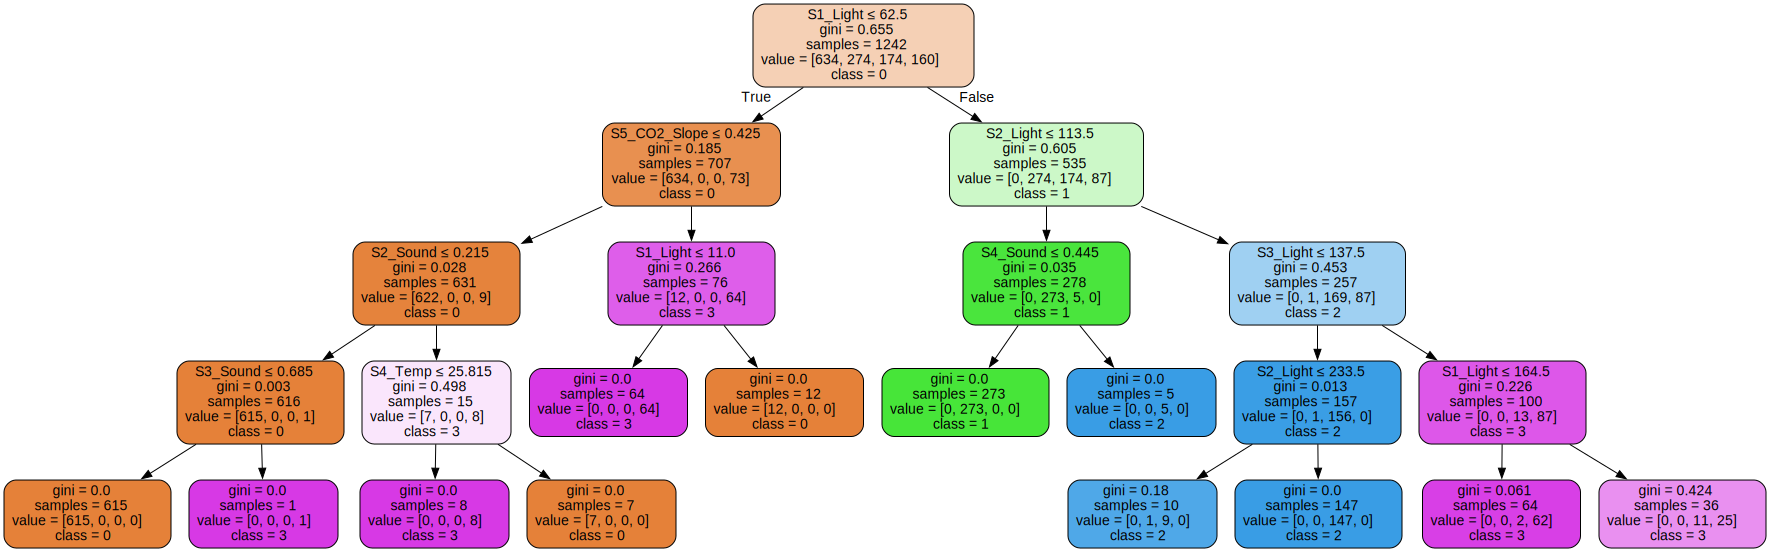

In [37]:
## Create decision tree classifier
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888, max_depth=4)
# Instatiate tree classifier
dt_clf = dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_test_pred = dt_clf.predict(X_test)
y_test_pred_prob = dt_clf.predict_proba(X_test)

macro_f1_tree, micro_f1_tree, weighted_f1_tree = calculate_f1_scores(y_test, y_test_pred)

sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# pp.pprint(('Features:', features))
# pp.pprint(('Feature importances:', dt_clf.feature_importances_))
# Plot decision tree with graphviz
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)

### Evaluate Decision Tree on test data (combine train and validation data)

In [38]:
# Concatenate train and val subsets into one set
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
X_train_val = np.concatenate((X_train, X_val))
print('X_train_val shape:', X_train_val.shape)

print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
y_train_val = np.concatenate((y_train, y_val))
print('y_train_val shape:', y_train_val.shape)

X_train shape: (1242, 16)
X_val shape: (2026, 16)
X_train_val shape: (3268, 16)
y_train shape: (1242,)
y_val shape: (2026,)
y_train_val shape: (3268,)


F1-Scores
---------
Macro average:    0.9650
Micro average:    0.9901
Weighted average: 0.9901



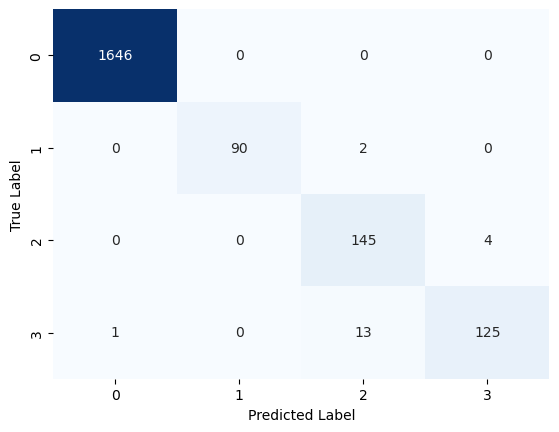

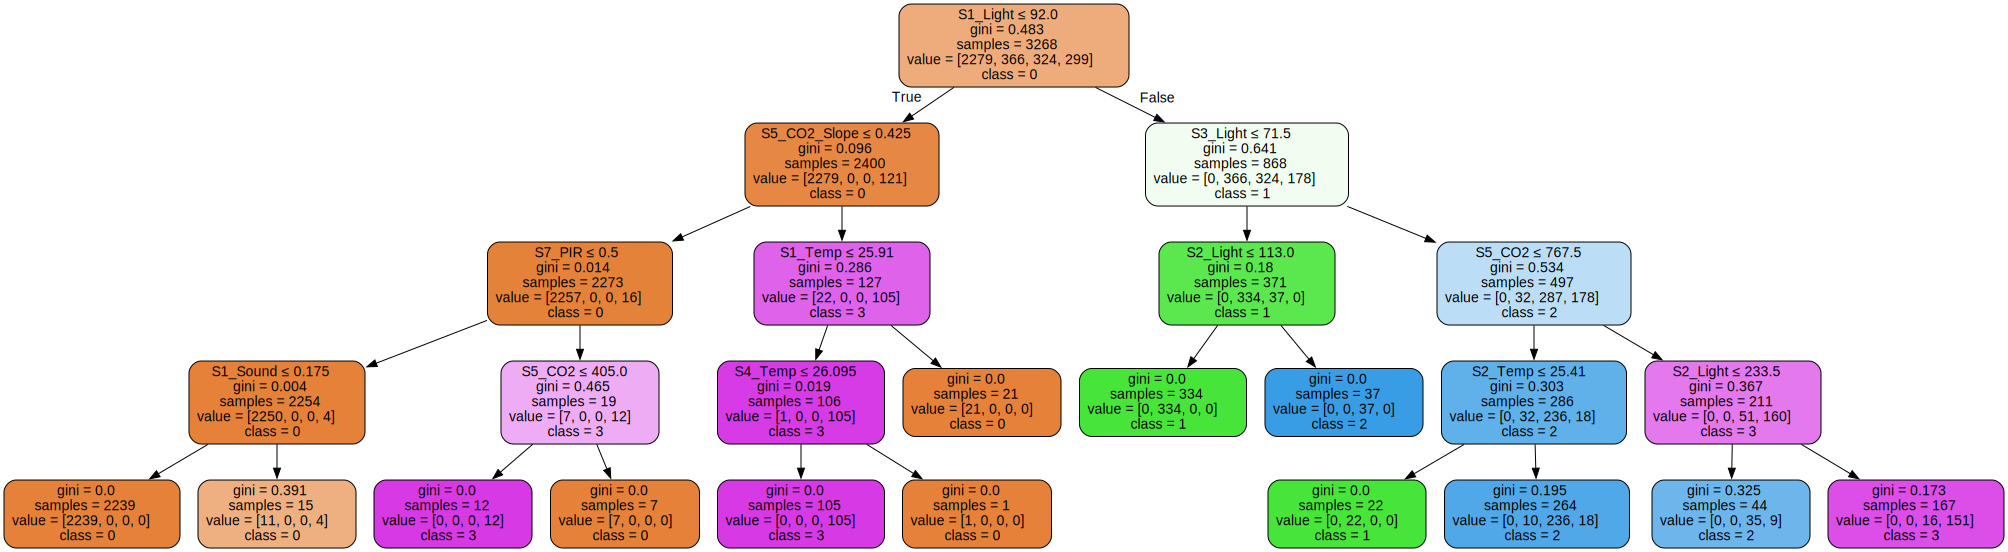

In [39]:
## Create decision tree classifier
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888, max_depth=4)

# Instatiate tree classifier
dt_clf = dt_clf.fit(X_train_val, y_train_val)

# Predict the validation data and the probabilities
y_test_pred = dt_clf.predict(X_test)
y_test_pred_prob = dt_clf.predict_proba(X_test)

macro_f1_tree, micro_f1_tree, weighted_f1_tree = calculate_f1_scores(y_test, y_test_pred)

sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)

## Gradient Boosted Decision Trees

### Gradient Boosted Decision Tree (determine importance of all features with default values)

In [ ]:
## Create gradient boosted decision tree classifier
# Use default values for parameters
gboost_dt_clf = GradientBoostingClassifier(random_state=888)
# gboost_dt_clf = GradientBoostingClassifier(learning_rate = 0.1,
#                                            n_estimators = 100,
#                                            max_depth = 3,
#                                            subsample = 1.0,
#                                            random_state=888)
# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate specificities
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]
# dot_data = tree.export_graphviz(gboost_dt_clf, out_file=None,
#                                 feature_names=features,
#                                 class_names=['0','1','2','3'],
#                                 filled=True, rounded=True,
#                                 special_characters=True,
#                                 # leaves_parallel=True,
#                                 )
# graph = graphviz.Source(dot_data, format='svg')
# display(graph)

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
display(df_gboost_dt_feature_importance)

### Gradient Boosted Decision Tree (Stumps)

In [ ]:
### Create gboosted decision tree 
macro_spec_tree, micro_spec_tree, weighted_spec_tree = get_gboost_decision_tree(max_depth=1)
# df_tree_specificities = pd.concat([df_tree_specificities, pd.DataFrame([[8, macro_spec_tree, micro_spec_tree, weighted_spec_tree]], columns=df_tree_specificities.columns)], ignore_index=True)
